# Orientações do Projeto



## Requisitos Obrigatórios:
* ~_Python versão 3.6 ou superior_~
*~_Código deverá ser versionado em repositório público no Github_~
* ~O algoritmo de classificação deve conter os seguintes passos~:
  * ~Realizar pré-processamento dos dados~;
  * ~determinar y_train~ ;
  * ~determinar x_train~;
  * ~Determinar a dinâmica do treinamento e dizer o porquê de ser utilizada~;
  * ~Determinar a métrica de avaliaçãão do modelo proposto: acurácia~.

## Critérios Obrigatórios:
* Explicar o processo de ~Aquisição do Conhecimento~ e ~Representação do Conhecimento~ utilizados para a resolução do problema
* ~Versionar o código no repositório do Github~
* Listar: 
  * ~O conjunto do domínio~; 
  * ~o conjunto de labels~;
  * ~as características dos dados de treinamento~;
  * ~a saída desejada~;
  * ~o modelo para a geração dos dados (ou conhecimento)~;
* ~Apresentar a métrica de avaliação do modelo proposto: acurácia~.



## Atentar:
* _~Como parte da solução, deverá analisar se a distribuição das classes irá ou não interferir no resultado do processo de classificação~_
* ~Todo o processo deverá estar documentado~

#Checking Python Version

In [132]:
!python --version

Python 3.6.9


# Dataset Importing from Kaggle

The dataset used to train the model can be found [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It is made up of Brain MRI Images. There are 98 samples labeled 'no' (no brain tumor) and 155 samples labeled 'yes' (brain tumor detected).

In [133]:
! pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [134]:
from google.colab import files
# Watch Out! Before running this cell, make sure kaggle.json is available in Colab's Folder.
# Then move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [135]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         81           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        182           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        272           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2161           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      17090           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4524           False  
connectx

In [136]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


The data is zipped in a file available in Google Colab's Files.

In [137]:
!unzip brain-mri-images-for-brain-tumor-detection.zip -d destination_folder

Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace destination_folder/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [180]:
import tensorflow as tf

main_directory = "destination_folder/brain_tumor_dataset"
brain_tumor_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=main_directory,
                                                                          labels='inferred',
                                                                          color_mode='grayscale')

Found 253 files belonging to 2 classes.


# Exploring the Dataset

In [ ]:
# Let's see the class names
brain_tumor_dataset.class_names

['no', 'yes']

## How The Data Looks Like

Now let's take a look at a chunk of our dataset. Below we can see we have greyscale images with shape 256x256 (due to the acquisition method applied). Our training data ```x_train``` will be these 1-channel images (float value matrices).

Each image below has a label over it. But I am not going to use them during training. Deep Learning models need numbers (greyscale float value matrix as the ```x_train``` and binary int values -1 or 0- as the ```y_train```) to work (learn). 

It is import to point out that, due to the structure of the dataset folder and due to the method ```tf.keras.preprocessing.image_dataset_from_directory()``` used, tumoral images will have the number _1_ associated with it and non tumoral images will have a number _0_ associated with it. This detail is important to the neural model I will use later on the code.

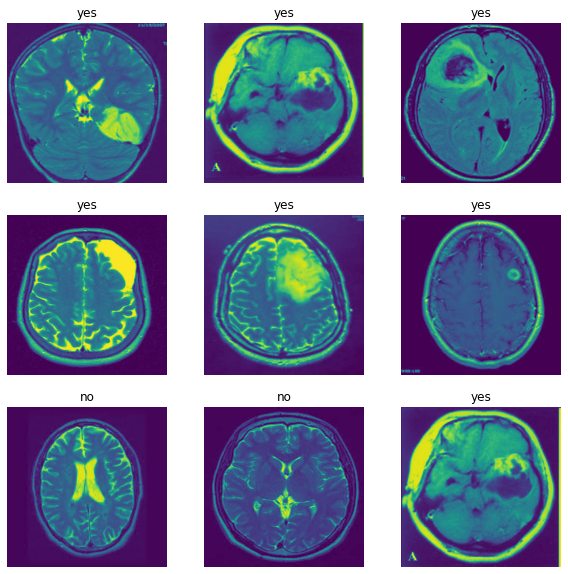

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in brain_tumor_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").squeeze())
    plt.title(brain_tumor_dataset.class_names[labels[i]])
    plt.axis("off")
  lbll = labels.numpy()

In [ ]:
# and here we can see the labels associated with the images above
lbll[0:9]

array([1, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

## Domain and labels



The previous explanation makes clear our Domain is the set of MRI images with tumoral brains and non-tumoral brains. Mathematically, it is a collection of matrices with size 256x256x1 and values in the range $[0,255]$.

The label set (or Counter-Domain) is the collection of target values associated with each MRI image. Mathematically, it is a collection of scalars that exist in the set ${0,1}$.

## Data Inbalance

As it was aforementioned, the class 'no' contains 98 samples and the class 'yes' contains 155 samples. An inbalance of ~2/3.
 
Below we can see some graphs to make clear the idea of data inbalance.

<BarContainer object of 2 artists>

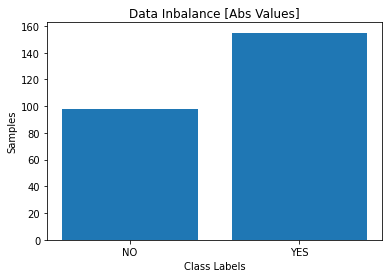

In [178]:
plt.title("Data Inbalance [Abs Values]")
plt.ylabel("Samples")
plt.xlabel("Class Labels")
plt.bar([0,1],[98,155], tick_label = ("NO","YES"))

<BarContainer object of 2 artists>

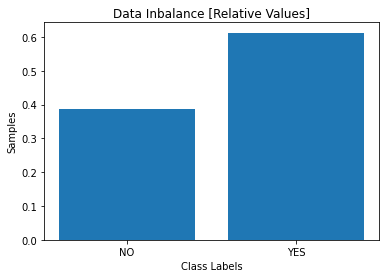

In [179]:
plt.title("Data Inbalance [Relative Values]")
plt.ylabel("Samples")
plt.xlabel("Class Labels")
plt.bar([0,1],[98/(98+155),155/(98+155)], tick_label = ("NO","YES"))

# Determining Training/Validation Set

In the codes below I partition the dataset in _training_ and _validation_ sets. 



## x_train and y_train

The variable ```train_ds``` is a container to the ```x_train``` and ```y_train``` that will be used. The characteristics of these data were detailed in the previous topic "How The Data Looks Like". 

In [ ]:
val_split = 0.3
chosen_seed = 123

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=main_directory,
                                                               labels='inferred', 
                                                               label_mode="binary",  
                                                               validation_split=val_split,  
                                                               subset="training",  
                                                               seed=chosen_seed,
                                                               color_mode='grayscale')

Found 253 files belonging to 2 classes.
Using 178 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=main_directory,
                                                             labels='inferred',  
                                                             label_mode='binary',
                                                             validation_split=val_split,
                                                             subset="validation",
                                                             seed=chosen_seed,
                                                             color_mode='grayscale')

Found 253 files belonging to 2 classes.
Using 75 files for validation.


# The Task: Brain Tumor Detector

## Creating the model

The Representation of Knowledge I will use is a _Convolutional Neural Network_. It is made up of a stack of three cells of Convolution-Max Pooling, followed by two Dense layers. Between the last Max Pooling layer and the first Dense layer there is a Flatten layer.

The last Dense layer has only one neuron with the sigmoid activation function. Why the sigmoid? Because we want to compute the probability that the binary variable is 1 (if the brain image contains a tumor or not). Notice this matches with the label data: 0 means "no tumor" and 1 means "tumor detected". So the sigmoid will output the probability of the image having a tumor. That is the desired output.

All the other layers contains ReLU activation function. This activation function has the advantage of being similar to the linear units even though they are non-linear. Models with behaviours closer to linear are easier to optimize.

The first layer of the model is a preprocessing one. It normalizes the input images. It is important to normalize the input data between 0 and 1 so the model will not manipulate too large values.  

Why to use a Convolutional Neural Network? Because we are dealing with images. A Dense Network would require too much parameters to connect the first layer (related to the image) to the next one. A CNN shortens this need. Also, the parameter sharing permits to detect local patterns at many locations in the image. The name of this property is Translation Invariance. 

The Max Pooling Layer guarantees Translation Invariance over smaller regions, further improving the idea of finding local patterns across all the image.

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256,1)),
                                    tf.keras.layers.Conv2D(filters=16,kernel_size=5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Conv2D(8,5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Conv2D(4,5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
                                    ])

Below we see the model created. We see the stack of layers and the trainable parameters in it.

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 8)       3208      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 57, 57, 4)         804       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 4)        

## Training Dynamics Setting

Since I will use a Convolutional Neural Network, the Knowledge Aquisition happens during training. That is, while the parameters (weights) are optimized to lower the Loss Function Value, the Hypotheses Space is searched so the optimal solution will be chosen.

The chosen optimizer is _Adam_. This optimizer can addapt to different loss surfaces.

The chosen loss function is _Binary Crossentropy_. It is "Binary" because the training data is binary. The crossentropy will drive the predicted values distribution to match the label distribution. It has the property of cancelling the saturation of the sigmoid also.

The chosen metric "accuracy" (the fraction of predictions the model got right) is determined also.

$$Accuracy = \frac{True Positives + True Negatives}{True Positives + True Negativas + False Positives + False Negatives}$$

In [ ]:
model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

## An Overfitting Training

"Always Overfit First". -Wojciech Czarnecki.



Let's train once to understand what is happening. As Wojciech Czarnecki says: "if you can't overfit a small sample, something's wrong".

After the training let's see what happened in some graphs.

In [ ]:
epochs = 50
history = model.fit(  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/50
6/6 [==============================] - 12s 2s/step - loss: 0.6739 - accuracy: 0.4840 - val_loss: 0.6096 - val_accuracy: 0.6667
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.5965 - accuracy: 0.6931 - val_loss: 0.6452 - val_accuracy: 0.7467
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.5243 - accuracy: 0.7501 - val_loss: 0.6592 - val_accuracy: 0.6000
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.4836 - accuracy: 0.7507 - val_loss: 0.6714 - val_accuracy: 0.7600
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 0.4340 - accuracy: 0.8135 - val_loss: 0.6568 - val_accuracy: 0.7600
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 0.4264 - accuracy: 0.8185 - val_loss: 0.5987 - val_accuracy: 0.7333
Epoch 7/50
6/6 [==============================] - 12s 2s/step - loss: 0.4251 - accuracy: 0.7868 - val_loss: 0.6534 - val_accuracy: 0.7733
Epoch 8/50
6/6 [==================

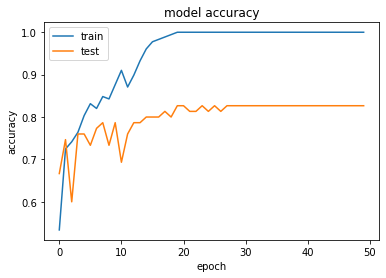

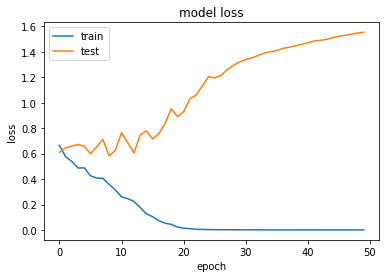

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Analysis and Conclusions

Above we can see a very curious phenomena: the training accuracy goes to 100%, while validation data plateaus at approximately 80%. 

In the loss plot we can see something as curious: the training loss goes down, while the validation data keeps increasing.

This episode has a name: overfitting. It happens when the model matches so perfectly the training data it fails to make useful predictions on unseen examples (the validation set).

Now we know we have two problems: we have an unbalanced dataset and we have a model that overfits. To solve this, let's augment our data!

# Improvements

## Augmenting the Dataset


I will augment the dataset by flipping some images around the vertical axis.

How to do this? I will choose 155-98=57 images from the dataset labeled with 'no' and flip it around the vertical axis. I choose to do this kind of data augmentation because I was afraid of creating unrealistic data with while using fancy stuff.

Actually, flipping this way is good because the model becomes robust due to the contextual tumor information (position invariation). That is: we help the model to understand a tumor is a tumor regardless where it is within the brain. Or, in this case: a healthy brain has no tumor everywhere.

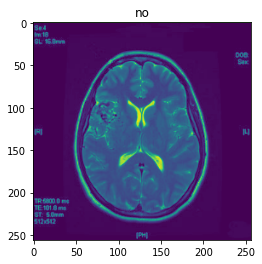

In [164]:
count_no_images_found = 0 # we should count up to 155-98
list_of_flipped_images = []

for imgg,lbls in brain_tumor_dataset.take(8): #take(8):
  if(count_no_images_found == 155-98):
    break
  #print("O 0 apareceu a seguinte quantidade de vezes = ",lbls.numpy().tolist().count(0))

  for it in range(0,lbls.shape[0]):
    #print("iterador igual a ",it)
    #print("valor de lbls no iterador: ",lbls.numpy()[it])
    if(lbls.numpy()[it]==0):
     # print("igual a 0 aqui")
      plt.imshow(imgg[it].numpy().astype("uint8").squeeze())
      plt.title(brain_tumor_dataset.class_names[lbls[it]])
      #print(imgg[it].numpy().shape)
      non_flipped_img = imgg[it]
      flipped_img = tf.image.flip_left_right(non_flipped_img)
      list_of_flipped_images.append(flipped_img)
      count_no_images_found = count_no_images_found + 1
      if (count_no_images_found == 155-98):
        break


In the previous cell a original image is displayed alongside with its label. Below we can see the flipped version of the image.

Text(0.5, 1.0, 'flipped image')

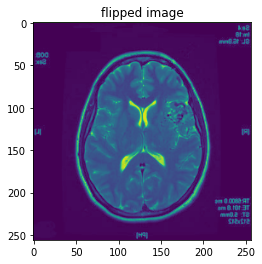

In [165]:
plt.imshow(flipped_img.numpy().astype("uint8").squeeze())
plt.title("flipped image")

Both images look equal, right? To know if there is any difference, let's display the difference of the original image and its flipped version:

Text(0.5, 1.0, 'difference image')

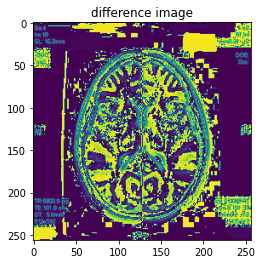

In [166]:
plt.imshow((non_flipped_img-flipped_img).numpy().astype("uint8").squeeze())
plt.title("difference image")

After seeing the difference of the two images, we notice that there are a lot of new information (where the two images "disagree") now.

Below I display the size of the image list to check out if there are really 57 new images. As it was expected, there are 57 new images.

In [ ]:
import numpy as np
np.shape(np.array(list_of_flipped_images))

(57, 256, 256, 1)

Below I create the labels to this augmented (flipped) subset. Since I want labels for class "0", I will create a list of 57 elements filled with '0'.

In [ ]:
flipped_images_labels = [[0]*57]

Below I create the TensorFlow dataset with the flipped images only. I call it ```augmented_dataset```.

In [ ]:
augmented_dataset=tf.data.Dataset.from_tensor_slices(([list_of_flipped_images],flipped_images_labels))

The ```new_dataset``` dataset is the concatanation of  ```brain_tumor_dataset``` and ```augmented_dataset```.

In [181]:
new_dataset = brain_tumor_dataset.concatenate(augmented_dataset)
new_dataset

<ConcatenateDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

## A Balanced Dataset

Augmenting the Dataset gives us a dataset with the same amount of samples to each class.

<BarContainer object of 2 artists>

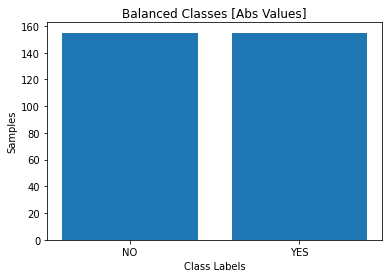

In [182]:
plt.title("Balanced Classes [Abs Values]")
plt.ylabel("Samples")
plt.xlabel("Class Labels")
plt.bar([0,1],[155,155], tick_label = ("NO","YES"))

<BarContainer object of 2 artists>

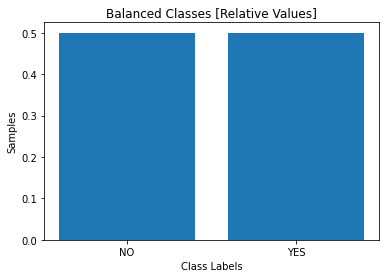

In [184]:
plt.title("Balanced Classes [Relative Values]")
plt.ylabel("Samples")
plt.xlabel("Class Labels")
plt.bar([0,1],[155/(155+155),155/(155+155)], tick_label = ("NO","YES"))

## Train and Validation Sets from New Dataset

The cell below separates the ```new_dataset``` into two parts: a validation set and a training set. Before the spliting I shuffle the dataset using the same seed as before (123).

The method below guarantees ```train_dataset``` has 32 samples (the same amount as the first approach).

In [185]:
new_dataset = new_dataset.shuffle(253,seed=123)

In [186]:
num_elements = 7 
val_dataset = new_dataset.take(num_elements)
train_dataset = new_dataset.skip(num_elements)

## Same Model, Same Training Dynamics

Let's create an object ```model2```. It is the same model as the object ```model```. I created another one so I will not use the first one again , which helps me to compare the two approaches (Inbalanced dataset and augmented dataset).

In [187]:
model2 = tf.keras.models.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256,1)),
                                    tf.keras.layers.Conv2D(filters=16,kernel_size=5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Conv2D(8,5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Conv2D(4,5,padding='valid',activation='relu'),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
                                    ])

Same training dynamics setting down there.

In [188]:
model2.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

## Training with the New Dataset

Let's train our model. Same amount of epochs again.

In [189]:
epochs = 50
history2 = model2.fit(  train_dataset,
  validation_data=val_dataset,
  epochs=epochs)

Epoch 1/50
2/2 [==============================] - 8s 5s/step - loss: 0.6717 - accuracy: 0.5919 - val_loss: 0.5744 - val_accuracy: 0.7828
Epoch 2/50
2/2 [==============================] - 7s 5s/step - loss: 0.5417 - accuracy: 0.8058 - val_loss: 0.7193 - val_accuracy: 0.6382
Epoch 3/50
2/2 [==============================] - 8s 5s/step - loss: 0.6202 - accuracy: 0.6562 - val_loss: 0.5728 - val_accuracy: 0.7033
Epoch 4/50
2/2 [==============================] - 7s 5s/step - loss: 0.4942 - accuracy: 0.7562 - val_loss: 0.5534 - val_accuracy: 0.7480
Epoch 5/50
2/2 [==============================] - 8s 5s/step - loss: 0.5071 - accuracy: 0.7396 - val_loss: 0.5893 - val_accuracy: 0.7269
Epoch 6/50
2/2 [==============================] - 8s 5s/step - loss: 0.4198 - accuracy: 0.8704 - val_loss: 0.5814 - val_accuracy: 0.7189
Epoch 7/50
2/2 [==============================] - 8s 5s/step - loss: 0.5658 - accuracy: 0.7188 - val_loss: 0.5562 - val_accuracy: 0.7236
Epoch 8/50
2/2 [=========================

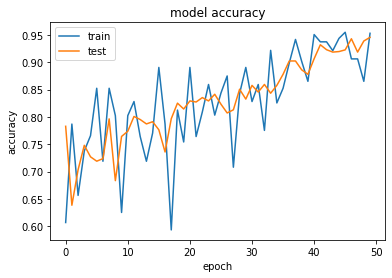

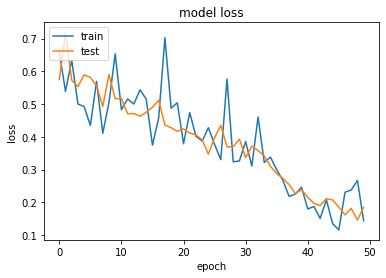

In [190]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Analysis and Conclusions

Now we have a better picture: the loss and the accuracy curves, with respect to training and validation sets, are near each other. That's brilliant!

It is important to mention that when we deal with inbalance datasets, accuracy is not a good measure of model's performance. But now we have a balanced dataset, due to the augmentation process. Furthermore, the accuracy with respect to training and validation sets are near each other and high! No overfitting anymore!

# References

[Deep Learning. Ian Goodfellow et al. MIT Press, 2016. Chapters 6 and 9.](https://www.deeplearningbook.org/)

[DeepMind x UCL | Deep Learning Lectures | 2/12 | Neural Networks Foundations](https://youtu.be/FBggC-XVF4M?t=4625)

[DeepMind x UCL | Deep Learning Lectures | 3/12 | Convolutional Neural Networks for Image Recognition](https://storage.googleapis.com/deepmind-media/UCLxDeepMind_2020/L3%20-%20UUCLxDeepMind%20DL2020.pdf)

[Machine Learning Crash Course Glossary](https://developers.google.com/machine-learning/glossary?hl=en#accuracy)

[Data Augmentation for Brain-Tumor Segmentation: A Review, by Jakub Nalepa, Michal Marcinkiewicz, and Michal Kawulok](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6917660/)

# Code Tips

* [How to download Kaggle Dataset;](https://www.loom.com/share/286a6817b8a1448eae904ca93d4f7560)

* [How to obtain Kaggle Public API](https://www.kaggle.com/docs/api) to conect Google Colab to Kaggle Dataset;

* [How to unzip files using linux-like commands.](https://askubuntu.com/questions/86849/how-to-unzip-a-zip-file-from-the-terminal)

* Here we have two references on how to encapsulate the dataset in a tensorflow object:
  * [Load Images Tutorial by Tensorflow](https://www.tensorflow.org/tutorials/load_data/images)
  * [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

* [How to Plot Images](https://www.tensorflow.org/tutorials/images/classification#visualize_the_data).

* On [image rescaling](https://www.tensorflow.org/tutorials/images/classification)

* On [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

* On [image dimension error during imshow displaying](https://stackoverflow.com/questions/15008045/showing-an-image-with-pylab-imshow)

* On [image dimension error in keras model](https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4)

* [One example of Notebook](https://www.kaggle.com/hussienelgabry/brain-tumour-detection-with-cnn-96-accuracy)

* [load images](https://www.codegrepper.com/code-examples/objectivec/how+to+load+images+from+folder+in+python)

* [flip images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right?hl=en)

* [TensorFlow Datasets from Image list](https://stackoverflow.com/questions/54933296/tensorflow-dataset-from-list-of-images-in-keras-model)

* [Splitting tf.data.Dataset into test and train](https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets)

* [Plotting History](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)